In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

from astropy.time import Time

from thor import Constants as c
from thor import rangeAndShift
from thor import preprocessObservations
from thor.observatories import getObserverState
from thor.utils import getHorizonsEphemeris
from thor.utils import getHorizonsVectors

from thor import __version__
print("THOR Version: {}".format(__version__))

/home/moeyensj/projects/thor/thor/thor/orbits/kepler.py:55: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  e_vec = ((v_mag**2 - mu / r_mag) * r - (np.dot(r, v)) * v) / mu
/home/moeyensj/projects/thor/thor/thor/orbits/kepler.py:77: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  trueAnom_deg = np.degrees(np.arccos(np.dot(e_vec, r) / (e * r_mag)))
/home/moeyensj/projects/thor/thor/thor/orbits/kepler.py:78: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  if np.dot(r, v) < 0:
/home/moeyensj/projects/thor/thor/thor/orbits/propagate/universal.py:46: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  rv_mag = np.dot(r, v) / r_mag
/home/moeyensj/projects/thor/thor/thor/orbits/iod/lambert.py:50

THOR Version: 1.1.dev69+gd5d3f05.d20200714


In [247]:
DATA_DIR = "/home/moeyensj/projects/thor/thor_data/kbmod/"
data = pd.read_csv(os.path.join(DATA_DIR, "2003_HC57.csv"))

data["obs_id"] = np.arange(1, len(data) + 1)
data["observatory_code"] = ["W84" for i in range(len(data))]
data["RA_sigma_deg"] = data["Dec_sigma_deg"] = 0.1/3600 * np.ones(len(data))

column_mapping = {
        "obs_id" : "obs_id",                             # Observation IDs 
        "mjd" : "MJD",                                   # MJDs (set scale with mjd_scale)
        "RA_deg" : "RA",                                 # RA in degrees (topocentric J2000)
        "Dec_deg" : "DEC",                               # Dec in degrees (topocentric J2000)
        "RA_sigma_deg" : "RA_sigma_deg",                 # 1-sigma error in RA in degrees 
        "Dec_sigma_deg" : "Dec_sigma_deg",               # 1-sigma error in Dec in degrees 
        "observatory_code" : "observatory_code",         # MPC observatory code
        "obj_id" : "targetname"                          # Object ID (designation) or NaN if unknown
}
observations, attributions = preprocessObservations(data, column_mapping, mjd_scale="utc")

0.020073790417427517


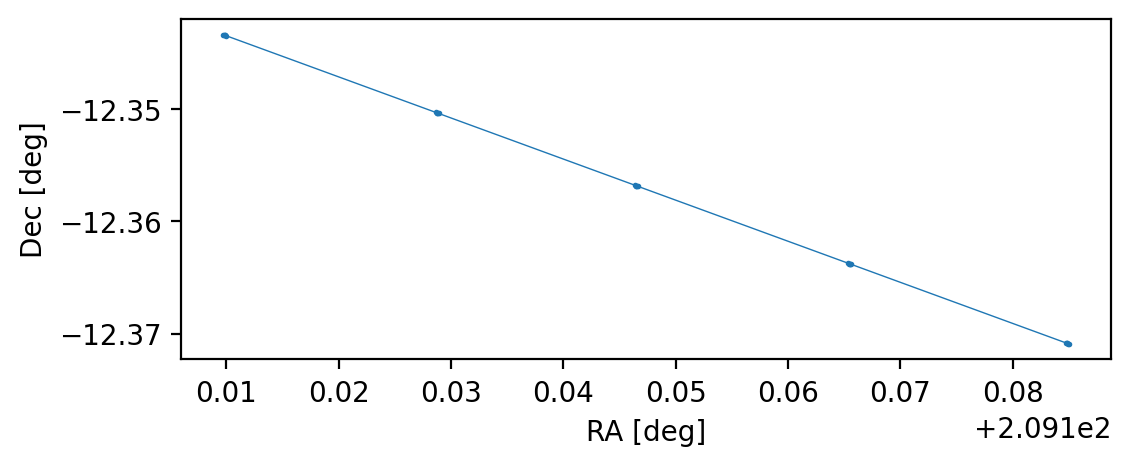

In [248]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*observations[['RA_deg', "Dec_deg"]].values.T, s=1)
ax.set_aspect("equal")
ax.set_xlabel(r"RA [deg]")
ax.set_ylabel(r"Dec [deg]")

ra_fit = np.linspace(
    observations["RA_deg"].min(),
    observations["RA_deg"].max(),
    100
)
lin_fit = np.polyfit(observations["RA_deg"].values, observations["Dec_deg"].values, 1)
dec_fit = np.polyval(lin_fit, ra_fit)
ax.plot(ra_fit, dec_fit, lw=0.5)

dec_residual = np.abs(observations["Dec_deg"].values - np.polyval(lin_fit, observations["RA_deg"].values))
print(np.mean(dec_residual) * 3600)

Query for targets of your choice here:

In [255]:
TARGETS = ["469509"]
MJDS = data["MJD"].values[0]

t0_initial = Time(MJDS, scale="utc", format="mjd")
observation_times = t0_initial + np.arange(0, 14)
observatory_code = "W84"

In [256]:
orbits = []
t0 = []
horizons_ephemeris = []

for target in TARGETS:
    # Pull state vectors from Horizons at initial epoch (used to set test orbits)
    horizons_vectors = getHorizonsVectors(target, t0_initial, location="@sun")
    orbit = horizons_vectors[['x', 'y', 'z','vx', 'vy', 'vz']].values
    orbits.append(orbit)
    t0.append(t0_initial.utc.mjd)
    
    # Generate ephemeris using Horizons at the observation times
    eph = getHorizonsEphemeris(target, observation_times, observatory_code)
    horizons_ephemeris.append(eph)
    
orbits = np.vstack(orbits)
t0 = Time(t0, format=t0_initial.format, scale=t0_initial.scale)

# Format Horizons ephemeris into "observations"
horizons_ephemeris = pd.concat(horizons_ephemeris)
horizons_ephemeris.reset_index(inplace=True, drop=True)
horizons_ephemeris["obs_id"] = np.arange(0, len(horizons_ephemeris), dtype=int).astype(str)
horizons_ephemeris["mjd_utc"] = Time(horizons_ephemeris["datetime_jd"].values, format="jd", scale="utc").utc.mjd

# Add errors (these are unused in this notebook but needed in THOR for IOD)
horizons_ephemeris["RA_sigma_deg"] = [0.1/3600 for i in range(len(horizons_ephemeris))]
horizons_ephemeris["Dec_sigma_deg"] = [0.1/3600 for i in range(len(horizons_ephemeris))]
horizons_ephemeris["observatory_code"] = [observatory_code for i in range(len(horizons_ephemeris))]

horizons_ephemeris.rename(columns={
    "RA" : "RA_deg",
    "DEC" : "Dec_deg"
    },
    inplace=True
)

# Ephemeris from Horizons now has every thing need to proceed

In [257]:
horizons_ephemeris.head()

,targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA_deg,Dec_deg,RA_app,...,r,r_rate,delta,delta_rate,lighttime,obs_id,mjd_utc,RA_sigma_deg,Dec_sigma_deg,observatory_code
0,469509 (2003 HC57),2014-Apr-23 02:00:45.388,2.456771e+06,5.8,0.15,,,209.184988,-12.370908,209.384769,...,42.756383,-0.268719,41.751211,-0.392301,347.234234,0,56770.083859,0.000028,0.000028,W84
1,469509 (2003 HC57),2014-Apr-24 02:00:45.388,2.456772e+06,5.8,0.15,,,209.165981,-12.363965,209.365772,...,42.756228,-0.268713,41.751276,0.128960,347.234772,1,56771.083859,0.000028,0.000028,W84
2,469509 (2003 HC57),2014-Apr-25 02:00:45.388,2.456773e+06,5.8,0.15,,,209.146989,-12.357023,209.346778,...,42.756073,-0.268707,41.751638,0.650358,347.237789,2,56772.083859,0.000028,0.000028,W84
3,469509 (2003 HC57),2014-Apr-26 02:00:45.388,2.456774e+06,5.8,0.15,,,209.128019,-12.350084,209.327798,...,42.755917,-0.268701,41.752299,1.171623,347.243284,3,56773.083859,0.000028,0.000028,W84
4,469509 (2003 HC57),2014-Apr-27 02:00:45.388,2.456775e+06,5.8,0.15,,,209.109077,-12.343151,209.308847,...,42.755762,-0.268695,41.753258,1.692446,347.251254,4,56774.083859,0.000028,0.000028,W84


Text(0.5, 0, 'Dec [deg]')

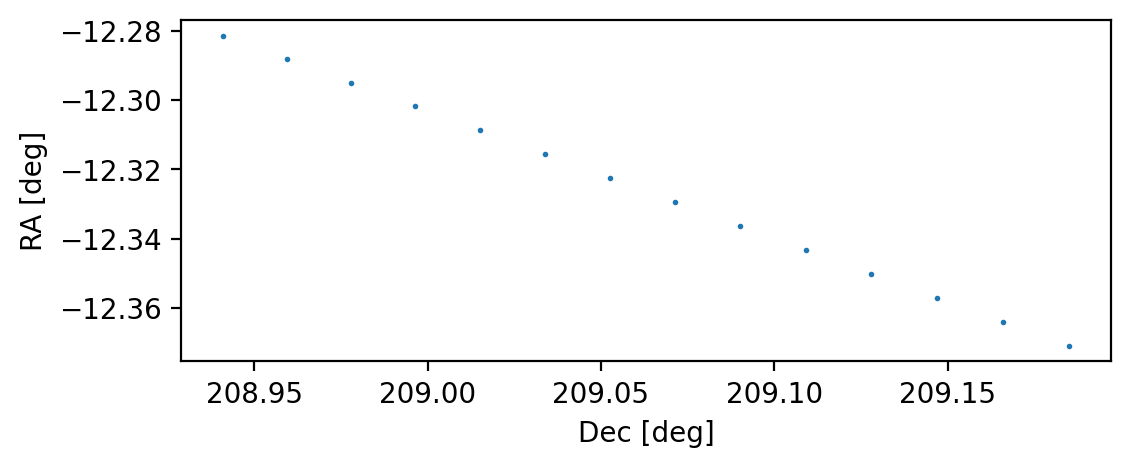

In [258]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*horizons_ephemeris[['RA_deg', "Dec_deg"]].values.T, s=1)
ax.set_aspect("equal")
ax.set_ylabel(r"RA [deg]")
ax.set_xlabel(r"Dec [deg]")

In [259]:
# Array of (N, 6) target orbits
orbits

array([[-3.64506858e+01, -2.23464754e+01, -2.96263437e-01,
         1.52492202e-03, -2.19105697e-03,  4.60199494e-05]])

In [260]:
# Corresponding (N) epochs
t0

<Time object: scale='utc' format='mjd' value=[56770.08385866]>

In [261]:
# Enter assumed heliocentric distance of test orbit
r = 4 # AU

# Calculate circular velocity at assumed distance
v = np.sqrt(c.G * c.M_SUN / r)

# Define test orbit at distance r with velocity v in the direction of 
# one of the target orbits
target_orbit_num = 0 # Set target orbit here -- corresponds to index in TARGETS list from earlier
test_orbit = np.zeros((1, 6))
test_orbit[0, :3] = r*(orbits[target_orbit_num,:3] / np.linalg.norm(orbits[target_orbit_num,:3]))
test_orbit[0, 3] = np.sqrt(v**2 / 2)
test_orbit[0, 4] = np.sqrt(v**2 / 2)
test_orbit[0, 5] = 0

In [262]:
# Cell area sets how large of circular area around the test orbit should be used to gather detections at each epoch (in degrees)
projected_observations = rangeAndShift(horizons_ephemeris, test_orbit, t0[:1], cell_area=1000000, backend="PYOORB")

THOR: rangeAndShift
-------------------------
Running range and shift...
Assuming r = [[-3.41008417 -2.09058789 -0.02771644  0.00608186  0.00608186  0.        ]] AU
Assuming v = [] AU per day
Done. Final DataFrame has 14 observations.
Total time in seconds: 0.15105962753295898
-------------------------



In [263]:
projected_observations.head()

,targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA_deg,Dec_deg,RA_app,...,Dec_sigma_deg,observatory_code,obs_x,obs_y,obs_z,obj_x,obj_y,obj_z,theta_x_deg,theta_y_deg
0,469509 (2003 HC57),2014-Apr-23 02:00:45.388,2.456771e+06,5.8,0.15,,,209.184988,-12.370908,209.384769,...,0.000028,W84,-0.846512,-0.542453,-4.910164e-06,-3.400512,-2.106471,-0.021257,0.265119,0.092519
1,469509 (2003 HC57),2014-Apr-24 02:00:45.388,2.456772e+06,5.8,0.15,,,209.165981,-12.363965,209.365772,...,0.000028,W84,-0.837390,-0.556930,-3.967881e-06,-3.384879,-2.115748,-0.021194,0.525293,0.093605
2,469509 (2003 HC57),2014-Apr-25 02:00:45.388,2.456773e+06,5.8,0.15,,,209.146989,-12.357023,209.346778,...,0.000028,W84,-0.828024,-0.571245,-2.886399e-06,-3.369177,-2.124979,-0.021133,0.786549,0.094671
3,469509 (2003 HC57),2014-Apr-26 02:00:45.388,2.456774e+06,5.8,0.15,,,209.128019,-12.350084,209.327798,...,0.000028,W84,-0.818415,-0.585394,-1.690106e-06,-3.353408,-2.134159,-0.021072,1.048841,0.095714
4,469509 (2003 HC57),2014-Apr-27 02:00:45.388,2.456775e+06,5.8,0.15,,,209.109077,-12.343151,209.308847,...,0.000028,W84,-0.808567,-0.599374,-4.105380e-07,-3.337574,-2.143285,-0.021013,1.312120,0.096737


Text(0.5, 0, '$\\theta_X$')

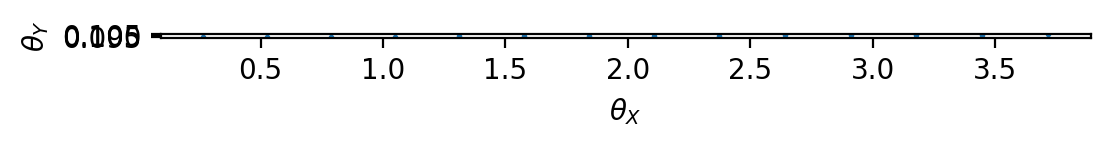

In [264]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*projected_observations[['theta_x_deg', "theta_y_deg"]].values.T, s=1)
ax.set_aspect("equal")
ax.set_ylabel(r"$\theta_Y$")
ax.set_xlabel(r"$\theta_X$")

(-0.01, 0.01)

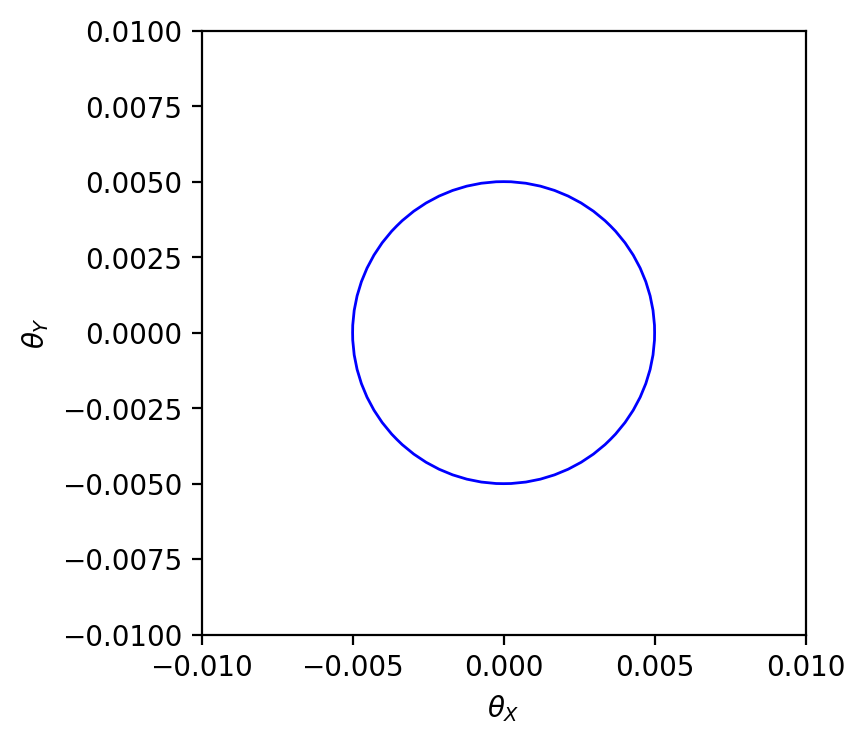

In [265]:
# Plot THOR clustering radius (probably not useful)
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*projected_observations[['theta_x_deg', "theta_y_deg"]].values.T, s=1)
circle = plt.Circle((0, 0), 0.005, color='b', fill=False)
ax.add_artist(circle)
ax.set_aspect("equal")
ax.set_ylabel(r"$\theta_Y$")
ax.set_xlabel(r"$\theta_X$")
ax.set_xlim(-0.01, 0.01)
ax.set_ylim(-0.01, 0.01)

Text(0.5, 0, 'Heliocentric Longitude [deg]')

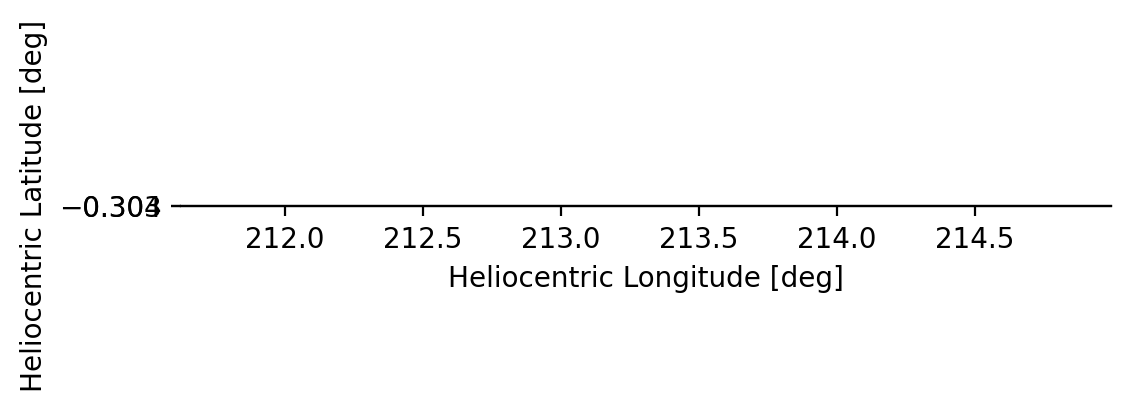

In [266]:
# Plot heliocentric longitude and latitude based on assumed test orbit 
from thor.coordinates import transformCoordinates

# Transform assumed heliocentric cartesian coordinates to their spherical representation
coords_ecliptic = transformCoordinates(
    projected_observations[["obj_x", "obj_y", "obj_z"]].values,
    "ecliptic",
    "ecliptic",
    representation_in="cartesian",
    representation_out="spherical"
)

fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(*coords_ecliptic[:, 1:3].T, s=1)
ax.set_aspect("equal")
ax.set_ylabel(r"Heliocentric Latitude [deg]")
ax.set_xlabel(r"Heliocentric Longitude [deg]")